<a href="https://colab.research.google.com/github/MayooranT/Fundamentals-of-Image-Processing/blob/main/EN2550_Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# .........**Assignment 05**.............
# ..............180391V..................


# **Part 1**

#### Import required libraries

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
%matplotlib inline
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Visualize the template image and the convey belt

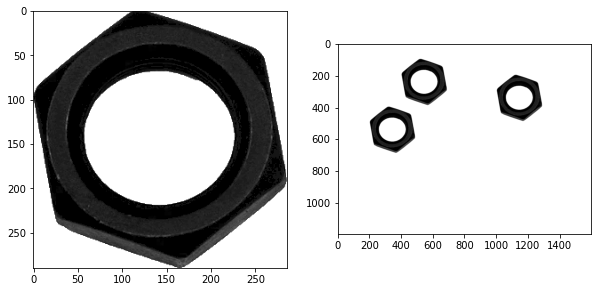

In [2]:
template_im = cv.imread(r'/content/drive/MyDrive/docements/CoLab files/template.png', cv.IMREAD_GRAYSCALE)
belt_im = cv.imread(r'/content/drive/MyDrive/docements/CoLab files/belt.png', cv.IMREAD_GRAYSCALE)
fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(template_im, cmap='gray')
ax[1].imshow(belt_im, cmap='gray')
plt.show()

#### Otsu’s thresholding

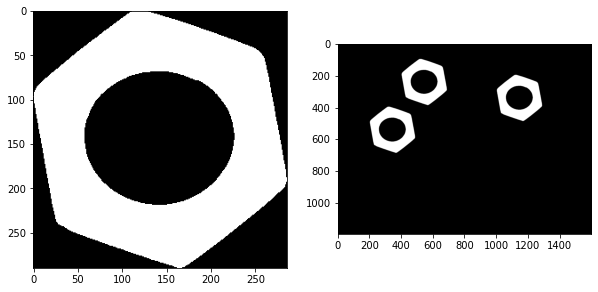

In [3]:
th_t, img_t = cv.threshold(template_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
th_b, img_b = cv.threshold(belt_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(img_t, cmap='gray')
ax[1].imshow(img_b, cmap='gray')
plt.show()

#### Morphological closing

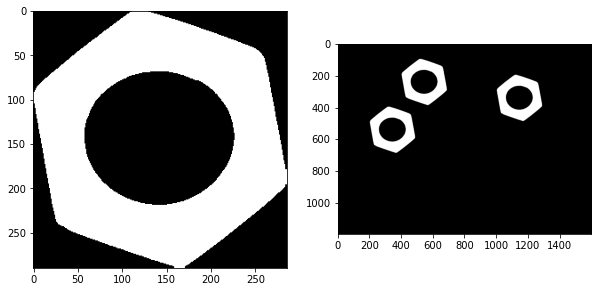

In [4]:
kernel = np.ones((3,3))
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel)
closing_b = cv.morphologyEx(img_b, cv.MORPH_CLOSE, kernel)

fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(closing_t, cmap='gray')
ax[1].imshow(closing_b, cmap='gray')
plt.show()

#### Connected component analysis

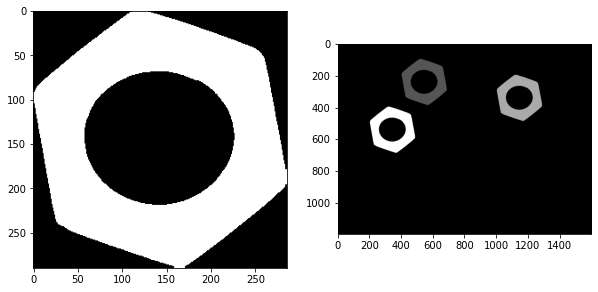

stats of templete : 
 [[    0     0   286   290 42290]
 [    0     0   286   290 40650]] 

centroids of templete : 
 [[142.18770395 145.19172381]
 [142.82489545 143.780369  ]]

stats of belt : 
 [[      0       0    1600    1200 1798161]
 [    400     100     286     290   40613]
 [   1000     200     286     290   40613]
 [    200     400     286     290   40613]] 

centroids of belt : 
 [[ 807.85728475  614.56805258]
 [ 542.82567158  243.78479797]
 [1142.82567158  343.78479797]
 [ 342.82567158  543.78479797]]


In [5]:
retval_t, labels_t, stats_t, centroids_t = cv.connectedComponentsWithStats(closing_t)
retval_b, labels_b, stats_b, centroids_b = cv.connectedComponentsWithStats(closing_b)

fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(labels_t, cmap='gray')
ax[1].imshow(labels_b, cmap='gray')
plt.show()

print('stats of templete : \n', stats_t, '\n\ncentroids of templete : \n', centroids_t)
print('\nstats of belt : \n', stats_b, '\n\ncentroids of belt : \n', centroids_b)

• How many connected compoonets are detected in each image?

    Template image: 2 connected components (including the background)

    Belt image: 4 connected components (including the background)

• What are the statistics? Interpret these statistics.

    They are some statistics about the connected components in a frame.
    Column 1: cv.CC_STAT_LEFT: the leftmost (x) coordinate which is the inclusive start of the bounding box in the horizontal direction.
    Column 2: cv.CC_STAT_TOP: the topmost (y) coordinate which is the inclusive start of the bounding box in the vertical direction.
    Column 3: cv.CC_STAT_WIDTH: the horizontal size of the bounding box.
    Column 4: cv.CC_STAT_HEIGHT: the vertical size of the bounding box.
    Column 5: cv.CC_STAT_AREA: the total area (in pixels) of the connected component.

• What are the centroids?

    These are the centroids of the contours which were identified. First lement in the list represents the centroids of the backgroud.

#### Contour analysis

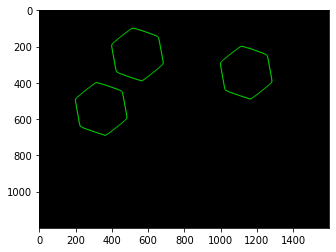

In [6]:
contours_t, hierarchy_t = cv.findContours(closing_t, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours_b, hierarchy_b = cv.findContours(closing_b, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Visualizing contours
im_contours_belt = np.zeros((belt_im.shape[0],belt_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_belt, contours_b, -1, (0,255,0), 3).astype('uint8')
plt.imshow(conts)

#### Count the number of matching hexagonal nuts in belt.png.

In [7]:
label = 1 # remember that the label of the background is 0
belt = ((labels_b >= label)*255).astype('uint8')
belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
for j,c in enumerate(belt_cont):
  print(cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0))

0.00010071698397151607
0.00010071698397928763
0.00010071698397484674


# **Part 2**

#### cv.contourArea()

In [8]:
ca = cv.contourArea(contours_b[1])
print(ca)

60059.5


#### cv.moments()

In [9]:
M = cv.moments(contours_b[1])
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
print(cx)
print(cy)

1142
343


#### object_prev_frame

In [10]:
count=1
object_prev_frame = [cx, cy, ca, count]

#### delta_x

In [11]:
delta_x=15

# **Part 3**

#### Implement the function get_indexed_image

In [12]:
def get_indexed_image(im):
  th_t, img_t = cv.threshold(im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU) #thresholding
  kernel = np.ones((3,3))  #kernel
  closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel)  #Closing
  retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing_t) #connected component analysis
  return retval, labels, stats, centroids

#### Implement the function is_new

In [13]:
def is_new(a, b, delta, i):
    absolute_different = np.absolute(a - b)
    absolute_different[:,i] = (absolute_different[:,i] > delta[i])  # checks every row of the selected coloum whether it is greater than delta
    #absolute_different is a coloum vector
    return absolute_different[:,i].all() # this returns true only when every element is true

In [14]:
# check is_new  expected answer False
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
              [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
              [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])

b = np.array( [7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])

assert is_new(a, b, delta, i) == False, " Check the function "

#### Implement the function prev_index

In [15]:
def prev_index(a, b, delta, i):
    absolute_different = np.absolute(a - b)
    # thresholding  depending on the movement of the cx from frame to frame
    absolute_different[:,i] = (absolute_different[:,i] <= delta[i]) 
    index = np.where(absolute_different[:,i]) # this returns the index and some more deatils
    index1=index[0] #filter out only the index
    return index1

In [16]:
# check prev_index  expected answer 1
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
              [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
              [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])

b = np.array( [7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
assert prev_index(a,b,delta,i) == 1, " Check the function "

#### Accessing each frame of the video

In [17]:
cap = cv.VideoCapture('/content/drive/MyDrive/docements/CoLab files/conveyor_with_rotation.mp4') # give the correct path here
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    print("Can't receive frame (stream end?). Exiting ...")
    break
  #cv2_imshow(frame)
  if cv.waitKey(1) == ord('q'):
    break
cap.release()
cv.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...


## **Implement a code to detect hexagonal nuts in a moving convey belt.**

#### Extarcting frames from the video

In [18]:
gray_frames = []  # a list to save all grey frames

cap = cv.VideoCapture('/content/drive/MyDrive/docements/CoLab files/conveyor_with_rotation.mp4') 
print("Video capturing is in progress...")
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY) # convert to grayscale
    gray_frames.append(frame) # appending gray frames
    
    if cv.waitKey(1) == ord('q'):
        break
        
cap.release()
cv.destroyAllWindows()
print("Video capturing completed.")

Video capturing is in progress...
Can't receive frame (stream end?). Exiting ...
Video capturing completed.


Find the contours of each frame

In [19]:
contour_plots = [] # storing the contours as a plottable format
contours_list = [] # storing the contours as it is
for gray in gray_frames:

    _, labels, _, _ = get_indexed_image(gray) # Use of all previously studied analysis
    belt = ((labels >= 1)*255).astype('uint8') 
    contours,_  = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours_list.append(contours)
    
    im_contours_belt = np.zeros((belt.shape[0],belt.shape[1],3), np.uint8)
    cont_plot = cv.drawContours(im_contours_belt, contours, -1, (0,255,0), 5).astype('uint8')
    contour_plots.append(cont_plot)

Visualize few adjuscent frames

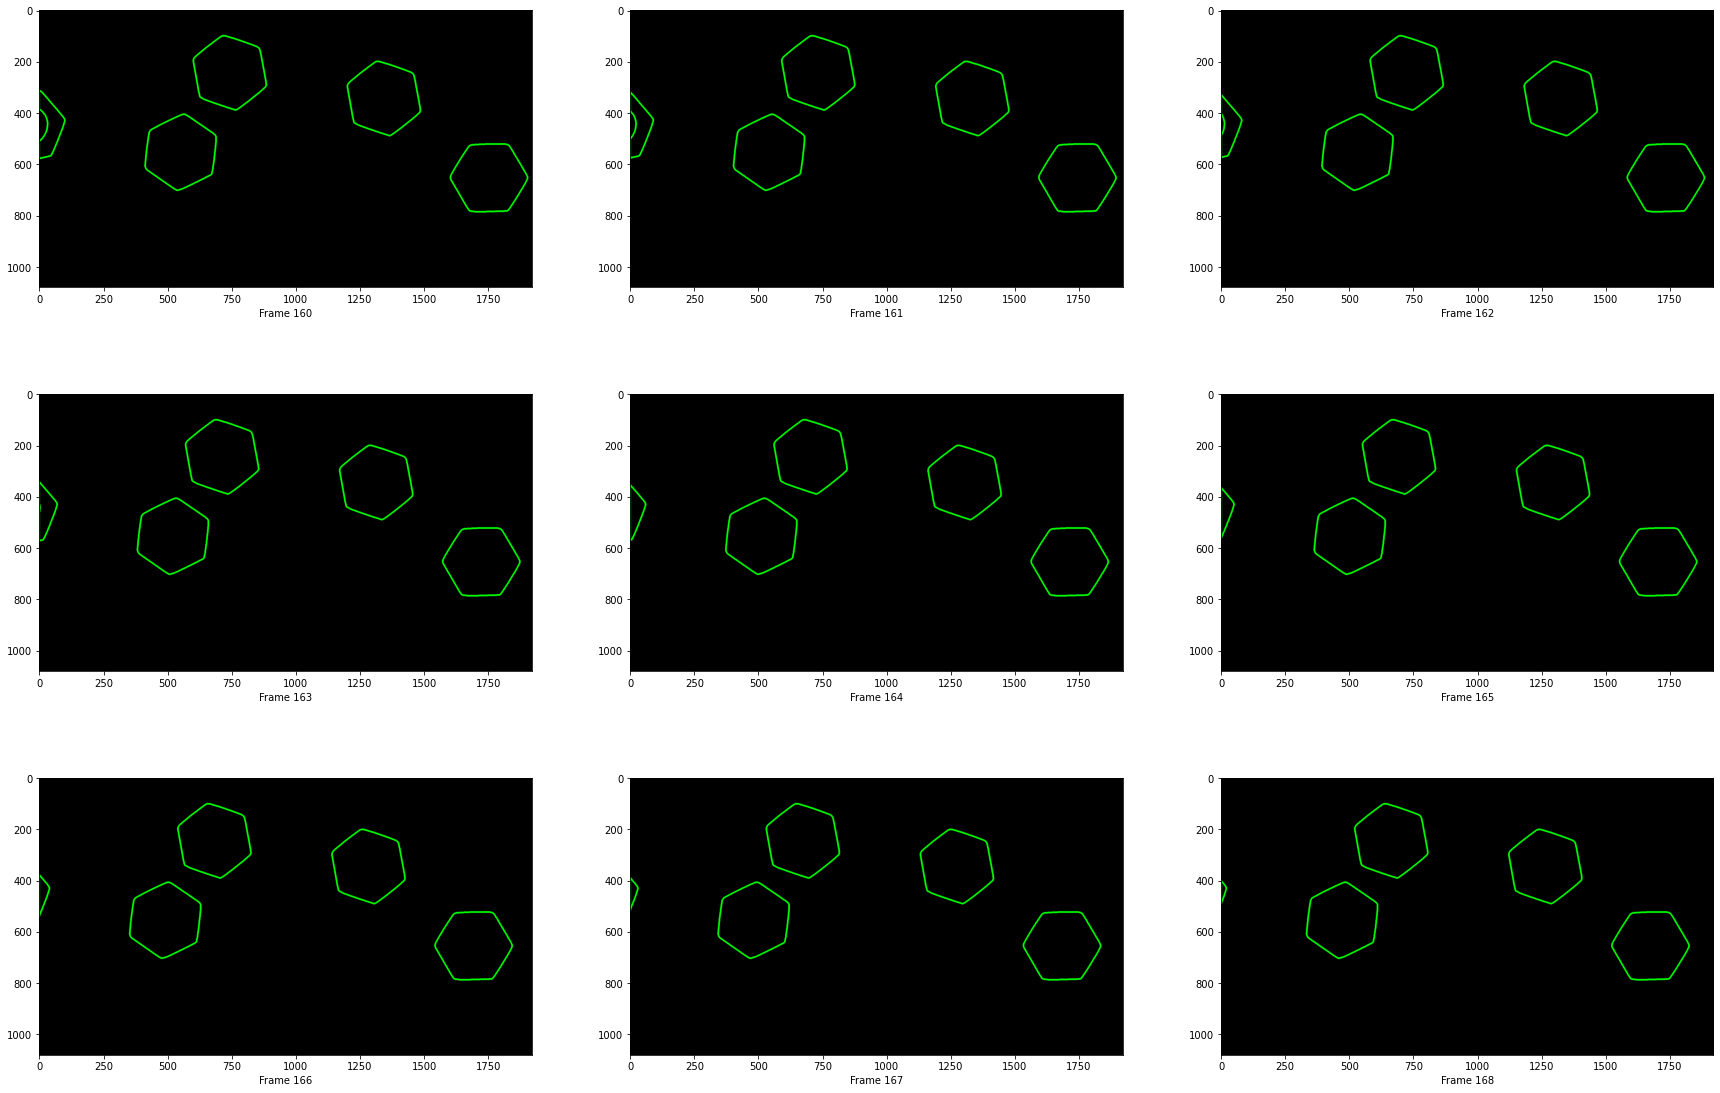

In [20]:
plt.figure(figsize=(30,20))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(contour_plots[160+i])
    plt.xlabel("Frame " + str(160+i))
plt.show()

#### Detect the nuts and extract its details frame by frame


In [21]:
video = []
print("........Extracting Details......")
for gray in gray_frames:
    
    _, labels, _, _ = get_indexed_image(gray) 
    belt = ((labels >= 1)*255).astype('uint8') 
    contours,_  = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    count = 0 
    frame = []
    
    for contour in contours:
        metric = cv.matchShapes(contours_t[0], contour, cv.CONTOURS_MATCH_I1, 0.0)
        
        if metric <= 0.5: # matching threshold is 0.5
            count +=1
            M  = cv.moments(contour)
            ca = M['m00']
            cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
            frame.append(np.array([cx, cy, ca, count])) 
    #the count of the last contour in the frame wil be the total nuts in that frame
    video.append(frame)
print("Extraction completed.")

........Extracting Details......
Extraction completed.


#### Finding the total nuts present in a video


In [22]:
total_nuts = int(video[0][-1][-1]) # total nuts in first frame

delta_x = np.array([15])
i = np.array([0])

prev_frame = video[0] #the initial reference frame is set manually

for frame_num in range(1, len(video)):
    current_frame = video[frame_num] #The frame to be compared   
    
    for nut in current_frame:
        if is_new(prev_frame, nut, delta_x, i):
            total_nuts +=1  #count only if it's a new nut
            nut[-1] = total_nuts
            # the last element of a contour is indexed of the total nuts upto then 
        else: 
            # if it's not new, the previous index should be kept
            nut_index = prev_index(prev_frame, nut, delta_x, i)
                     
            nut[-1]=prev_frame[int(nut_index)][-1]
        
    prev_frame = current_frame 
    
    #current frame is set to be the previous frame for the next frame
print("Total number of nuts found: ",total_nuts)

Total number of nuts found:  5


#### Frame annotation

In [23]:
annotated_frames =[] 
frame_num = 0
print("Frame annotation is in progress...")
for frame,contour_plot, contours in zip(video, contour_plots, contours_list):
    
    img = contour_plot
    y = 0     # to change the position
    for nut in frame:
        
        # Annotate the index of the nut
        img = cv.putText(img, str(int(nut[-1])),\
               (int(nut[0]),int(nut[1])),cv.FONT_HERSHEY_SIMPLEX, 2, (128,0,128), 4)
        
        # Annotate the Connected componets' details
        img = cv.putText(img, "Object {}: {:04} {:04} {:05}".format(int(nut[-1]), int(nut[0]), int(nut[1]), nut[2]),\
                         (50,850 + 70*y), cv.FONT_HERSHEY_SIMPLEX, 2, (128,0,128), 4)
        
        y +=1     # to change the position
    
    # Annotate frame number
    img = cv.putText(img, "Frame "+str(frame_num) , (50,750) , cv.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 3)
    # Draw the contours
    img = cv.drawContours(img, contours, -1, (0,255,0), 5).astype('uint8')
    
    img = cv.putText(img, "180391V" , (50,150) , cv.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3) #Annotate index number
    annotated_frames.append(img)
    frame_num +=1
print("Annotation completed.")

Frame annotation is in progress...
Annotation completed.


#### Visualize some samples

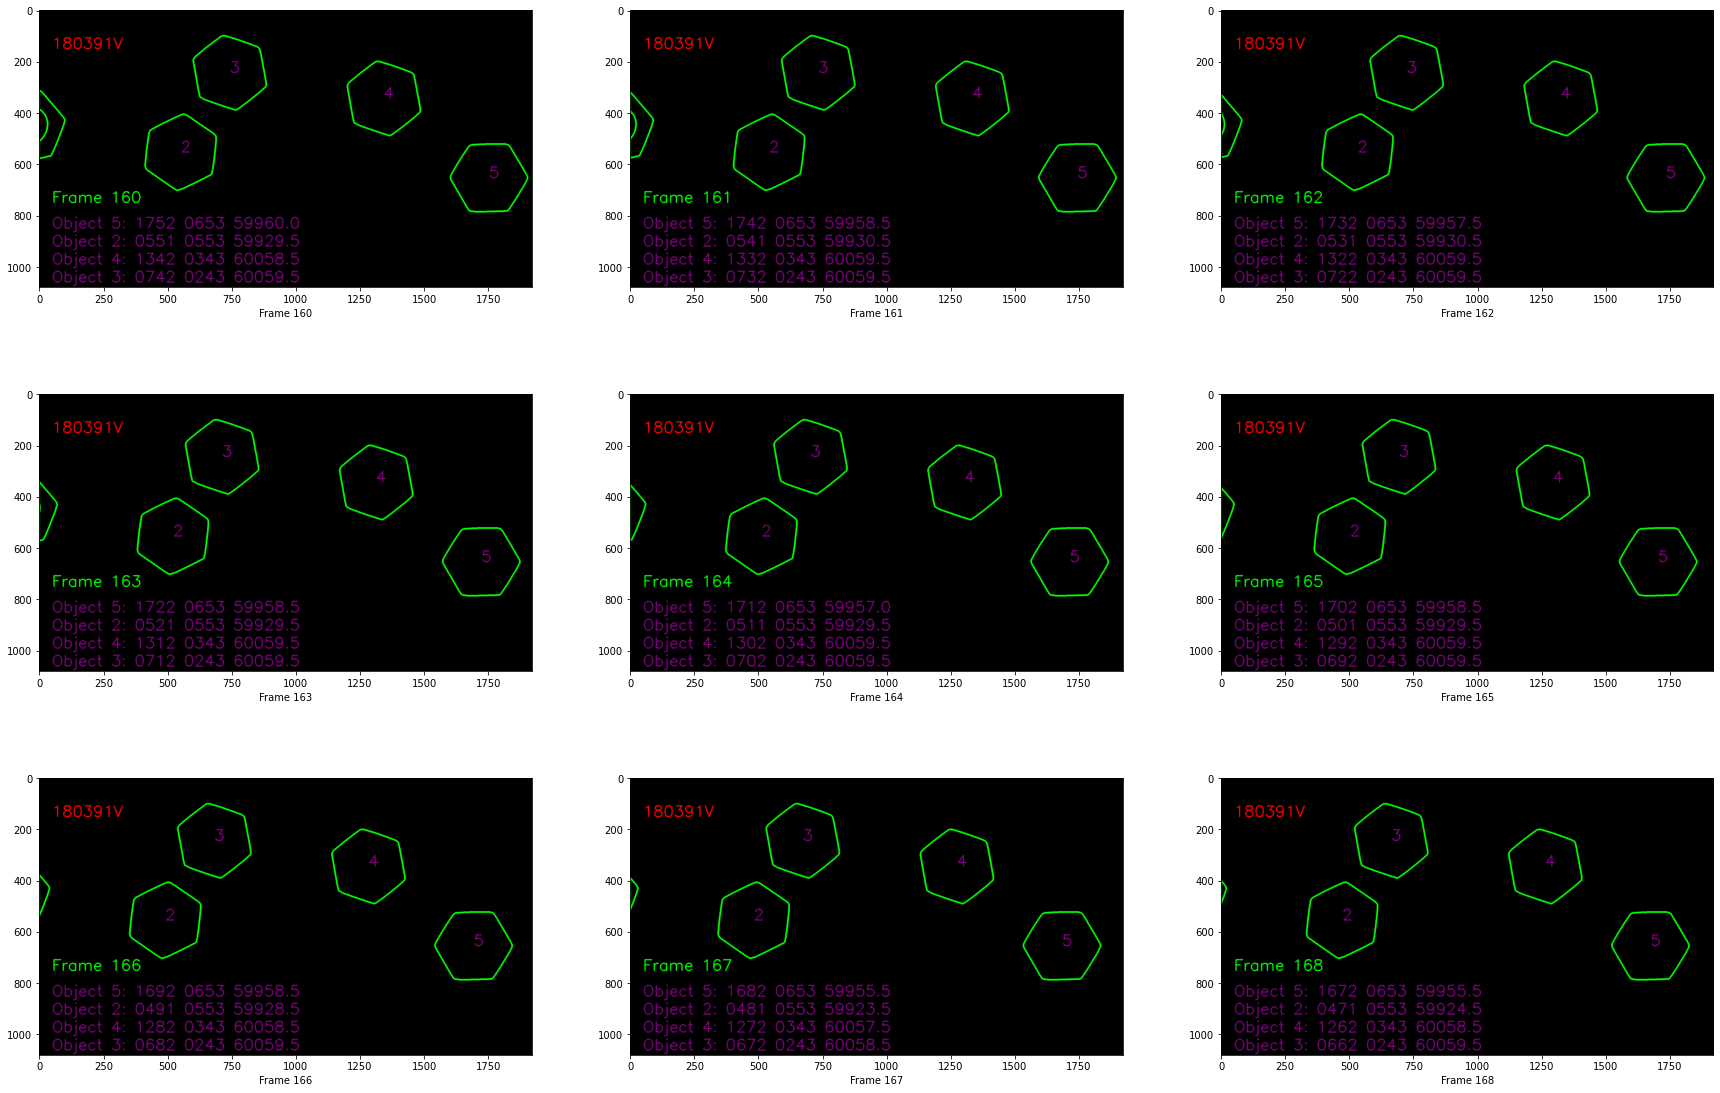

In [28]:
plt.figure(figsize=(30,20))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(annotated_frames[160 +i])
    plt.xlabel("Frame " + str(160 +i))
plt.show()

#### Save the frames as a video

In [25]:
output = '180391V_en2550_a05.mp4' 
fourcc = cv.VideoWriter_fourcc(*'MP4V') 
duration = 9 # initial video's duration
fps = int(len(annotated_frames)/duration) # frame per second
height, width,_ = annotated_frames[0].shape
frame_size = (width, height)
isColor = True 

# Creating the Video Writer object
out = cv.VideoWriter(output, fourcc, fps, frame_size, isColor)
print("Video writer in progress...")
for frame in annotated_frames:
    out.write(frame)

# finishing
out.release()
print("Video writing completed.")

Video writer in progress...
Video writing completed.
